In [ ]:
#    Copyright 2020 Arkadip Bhattacharya

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#        http://www.apache.org/licenses/LICENSE-2.0

#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.

### Wind speed Prediction

This notebook contains all necessary codes to Train a `Deep Learning Model` and Validate it.

The Model is based on `Pytorch`

In [1]:
## Importing all the necessary Libraries along with some self-made functions

%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import dataloader
from sklearn.model_selection import train_test_split

from preprocessing import Normalize_df, WindSpeedDataset, WindSpeedTimeSeriesDataset, ComposeTransform, ToTensor

In [2]:
# Reading the Dataset
# Nomalizing it using self-made *Normalize_df* function and returns a Pandas.Dataframe

dataset = Normalize_df(pd.read_csv('./dataset-daily.csv'))
dataset.head()

,time,air_temperature_mean,pressure,wind_direction,wind_speed
0,0.000000,0.370203,0.103164,0.732591,0.625000
1,0.000011,0.322799,0.268912,0.838440,0.354167
2,0.000022,0.302483,0.709078,0.988858,0.260417
3,0.000033,0.246050,0.850758,0.239554,0.093750
4,0.000044,0.194131,0.827372,0.345404,0.291667


In [3]:
# Spliting the Dataset into Train Set, Test Set and Validation Set

trainset, testset = train_test_split(dataset, test_size = 0.1)
trainset, valset = train_test_split(trainset, test_size = 0.1)

In [4]:
# A Example Training Attributes

trainset.iloc[0]

time                    0.448941
air_temperature_mean    0.564334
pressure                0.699449
wind_direction          0.757660
wind_speed              0.302083
Name: 1746, dtype: float64

In [5]:
# Creating the Time Series dataset Generators with window_size=6
# Using the ComposeTranform to Tranform each Time Series matrics into a Torch.Tensor

train_dataset = WindSpeedTimeSeriesDataset(trainset, window_size=6, transform=ComposeTransform([ToTensor()]))
test_dataset = WindSpeedTimeSeriesDataset(testset, window_size=6, transform=ComposeTransform([ToTensor()]))
val_dataset = WindSpeedTimeSeriesDataset(valset, window_size=6, transform=ComposeTransform([ToTensor()]))

In [6]:
# The first Time Series features matix
# Each row corresponding to a different times
# Each variables in a time signifies a feature

train_dataset[0][0]

tensor([[0.5643, 0.6994, 0.7577],
        [0.5056, 0.4642, 0.6435],
        [0.8036, 0.4849, 0.6184],
        [0.4515, 0.5048, 0.7409],
        [0.6208, 0.4298, 0.4930],
        [0.5869, 0.3343, 0.5738]], dtype=torch.float64)

In [7]:
# The first Time Series labels vector
# Each row is a label of different times

train_dataset[0][1]

tensor([[0.3021, 0.6146, 0.1562, 0.3958, 0.2812, 0.3750]], dtype=torch.float64)

In [8]:
# Genarating Pytorch DataLoader for the Training and Testing of the Model
# Setting the Batch size

batch_size = 32

trainloader = dataloader.DataLoader(train_dataset, batch_size, shuffle = True)
valloader = dataloader.DataLoader(val_dataset, batch_size, shuffle = False)
testloader = dataloader.DataLoader(test_dataset, batch_size, shuffle = False)

In [9]:
# Checking the Size of the Features and Label matrix
# Features Size = (Batch_size, Time_steps, no_of_features)
# Leabels Size = (Batch_size, Time_steps, no_of_labels)

f, l = next(iter(trainloader))

print(f'Features Size: {f.shape}')
print(f'Labels Size: {l.shape}')

Features Size: torch.Size([32, 6, 3])
Labels Size: torch.Size([32, 1, 6])


In [10]:
# Checking for the GPU for using Hardware Accelerations
# Set the `cuda` and `device` variables accordingly to use the correct device

cuda = torch.cuda.is_available()
device = torch.device('cuda') if cuda else torch.device('cpu')
if cuda:
    print("Device Count:", torch.cuda.device_count())
    print("Device:", torch.cuda.get_device_name())
    print("Device Capability:", torch.cuda.get_device_capability())

Device Count: 1
Device: GeForce 940MX
Device Capability: (5, 0)


In [11]:
# Importing the Model from model.py
# Setting the Model hyperparameters and create an instance of it
# Send the model to the appropriate device

from model import Model
model = Model(input_size = 3,
              lstm_input_size = 51,
              lstm_hidden_size = 102,
              time_series = 6,
              lstm_num_layers = 1,
              cuda=cuda)
model.to(device)
print(model)

Model(
  (conv1): Conv1d(6, 18, kernel_size=(1,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=54, out_features=51, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (lstm3): LSTM(51, 102, batch_first=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=102, out_features=51, bias=True)
  (drop4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=51, out_features=6, bias=True)
)


In [12]:
# Setting Up training criteria

from torch import nn
from torch.optim import Adam

optimizer = Adam(params=model.parameters(), lr= 0.001)
criterion = nn.SmoothL1Loss()

In [13]:
# loading the pretrained model

model.load_state_dict(torch.load(os.path.join('model', path, 'model.pt'), map_location=device))
optimizer.load_state_dict(torch.load(os.path.join('model', path, 'optim.pt'), map_location=device))

NameError: name 'path' is not defined

In [14]:
# Set the Model Optimizer, Using 'Adam'
# Set the Loss Function, Using 'SmoothL1Loss'
# Running the training routing


epochs = 20
trainlosses, testlosses = model.fit(trainloader = trainloader,
                                    validationloader = valloader,
                                    criterion = criterion,
                                    optimizer = optimizer,
                                    epochs = epochs, 
                                    val_per_batch = 20)

92/92 [==============================] - 16s 169ms/step - Epoch: 20.0000 - Training Loss: 1.1436e-04 - Test Loss: 0.00862s - Epoch: 20.0000 - Training Loss: 1.1365e-04 - Test


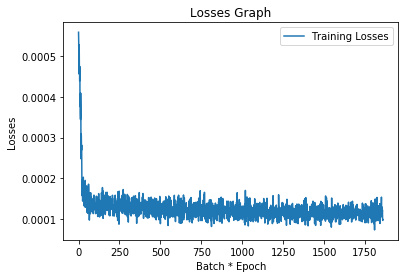

In [16]:
# Ploting the Loss stats

plt.plot(trainlosses, label = 'Training Losses')
#plt.plot(testlosses, label = 'Testing Losses')
plt.ylabel('Losses')
plt.xlabel('Batch * Epoch')
plt.legend()
plt.title('Losses Graph')
plt.show()

In [17]:
# Running the model test
# Ruturns the result and actual arrayes

result, actual = model.test(testloader)

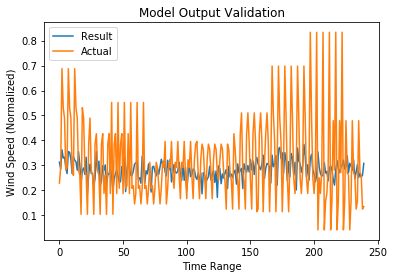

In [18]:
# Ploting the Validation Graph

# Just some random checking
%matplotlib inline
val_from = 0
val_to = 240

plt.plot(result[val_from:val_to], label = 'Result')
plt.plot(actual[val_from:val_to], label = 'Actual')
plt.ylabel('Wind Speed (Normalized)')
#plt.xticks(range(val_from, val_to))
plt.xlabel('Time Range')
plt.legend()
plt.title('Model Output Validation')
plt.show()

In [19]:
# Saving the Model

model.save_dict('lstm-v1', save_optim=True)

lstm-v1  - dir Already exists
Model saved in lstm-v1
Optimizer saved in lstm-v1


In [20]:
# save model summary

model.save_summary('lstm-v1')

lstm-v1  - dir Already exists
Summary Saved!


In [46]:
model.errors(testloader)

MAE:  0.11091697588562965
MSE:  0.13980445948739847
MAPE:  0.630652350684007
